In [74]:
import pandas as pd
import geopandas as gp
from shapely.geometry import Point
import datetime
import numpy as np
import altair as alt
import matplotlib

from lib.ball_tree_numba_parallel import BallTree

Створюємо датафрейм

In [36]:
crimes_data = pd.read_csv('data/sioux.csv', ',')

Вказуємо колонку з значеннями дати та часу, індексуємо її

In [37]:
crimes_data['dateTimeLocal'] =  pd.to_datetime(crimes_data['dateTimeLocal'])
crimes_data = crimes_data.set_index('dateTimeLocal').tz_localize(None)

Вказуємо географічні координати

In [40]:
crimes_data['geometry'] = crimes_data.apply(lambda z: Point(z.longitude, z.latitude), axis=1)
crimes_data = gp.GeoDataFrame(crimes_data)

У нас уже сформовано геодатафрейм, можемо з ним далі працювати

In [42]:
crimes_data.head()

,longitude,latitude,type,areaId,geometry
dateTimeLocal,,,,,
2018-08-22 03:00:00,-96.748740,43.527642,theft,sd/vermillion,POINT (-96.7487402 43.5276424)
2018-11-25 10:22:00,-96.713797,43.535246,other,siouxfalls,POINT (-96.71379709999999 43.5352461)
2018-11-25 13:57:00,-96.758714,43.556600,burglary,siouxfalls,POINT (-96.75871429999999 43.55659970000001)
2018-11-25 08:48:00,-96.660543,43.559458,theft,siouxfalls,POINT (-96.6605429 43.5594581)
2018-11-24 10:08:00,-96.754060,43.564017,vandalism,siouxfalls,POINT (-96.75405979999999 43.5640169)


In [43]:
crimes_2018 = crimes_data['2017-11-25 13:22:00' : '2018-11-25 13:22:00']

crimes_2018.head(5)

,longitude,latitude,type,areaId,geometry
dateTimeLocal,,,,,
2018-08-22 03:00:00,-96.748740,43.527642,theft,sd/vermillion,POINT (-96.7487402 43.5276424)
2018-11-25 10:22:00,-96.713797,43.535246,other,siouxfalls,POINT (-96.71379709999999 43.5352461)
2018-11-25 08:48:00,-96.660543,43.559458,theft,siouxfalls,POINT (-96.6605429 43.5594581)
2018-11-24 10:08:00,-96.754060,43.564017,vandalism,siouxfalls,POINT (-96.75405979999999 43.5640169)
2018-11-24 12:54:00,-96.797342,43.501601,other,siouxfalls,POINT (-96.7973418 43.5016015)


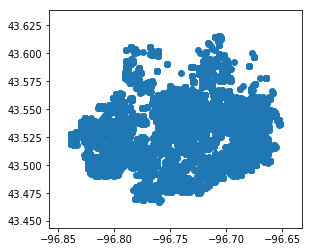

In [75]:
crimes_2018.plot()

In [ ]:
min_date = crimes_2018.index.min()
max_date = crimes_2018.index.max()

Перевіряємо дату першого та останнього значення

Створюємо датафрейм для подальшої візуалізації в ролі гістаграми

In [56]:
crimes_hist = pd.DataFrame(crimes_2018.index)
crimes_hist.head()

,dateTimeLocal
0,2018-08-22 03:00:00
1,2018-11-25 10:22:00
2,2018-11-25 08:48:00
3,2018-11-24 10:08:00
4,2018-11-24 12:54:00


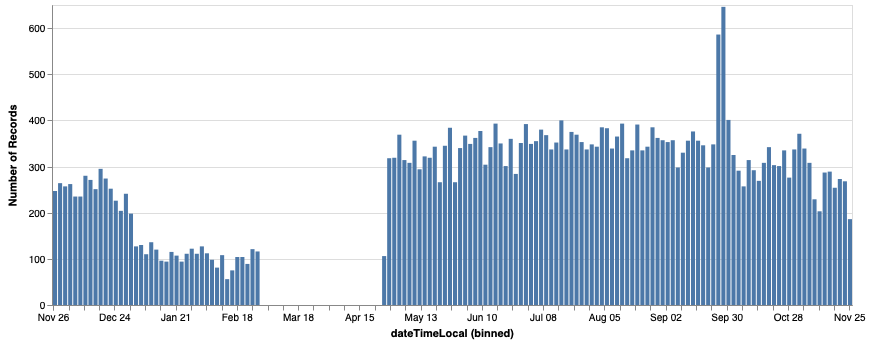

In [57]:
alt.data_transformers.enable('default', max_rows=None)
alt.Chart(crimes_hist).mark_bar().encode(
    alt.X('dateTimeLocal', bin=alt.BinParams(maxbins=200)),
    y='count()',
).properties(
    width=800,
    height=300
)

Наступний блок - розрахунок мінімальних відстаней між об'єктами

In [58]:
points_array = np.stack(crimes_2018['geometry']).astype(np.float32)
bt = BallTree(points_array, leaf_size=5)
dist, ind = bt.query(X=points_array, k=2, use_gpu=False)

In [59]:
min_distances = [x[1] for x in dist]
sum(min_distances) / crimes_2018.shape[0]

2.5191946310738054

In [67]:
min_dist_df = pd.DataFrame(columns=['x','observed','expected','ann','count']) #create an empty dataframe for visualizing the results
local_min = min_date

area = 169607989

while True:
    local_max = local_min + pd.DateOffset(7) #the daterange for analysis
    if local_max > max_date: #check of we are in a datetime range
        break
    subset = crimes_2018[str(local_min) : str(local_max)]
    
    try:
        #calculating observed distance
        points_array = np.stack(subset['geometry']).astype(np.float32)
        bt = BallTree(points_array, leaf_size=5)
        dist, ind = bt.query(X=points_array, k=2, use_gpu=False)
        min_distances = [x[1] for x in dist]    
        nnd = sum(min_distances) / subset.shape[0]
        
        #calculating expecting distance
        density = subset.shape[0] / area
        nnd_r = 1 / (2 * np.sqrt(density))
        
        # calculating index
        ann = nnd / nnd_r
        
        #add results to the dataframe to visualize
        min_dist_df = min_dist_df.append({
        'x': local_max, 
        'observed': nnd,
        'expected': nnd_r,
        'ann': ann,
        'count': subset.shape[0]
    }, ignore_index=True)
        
    except ValueError:
        #add results to the dataframe to visualize
        min_dist_df = min_dist_df.append({
            'x': local_max, 
            'observed': 0,
            'expected': 0,
            'ann': 0,
            'count': 0
        }, ignore_index=True)
    
    
    #change local min for the next iteration
    local_min = local_min + pd.DateOffset(1) 

In [69]:
min_dist_df.head()

,x,observed,expected,ann,count
0,2017-12-02 14:20:00,97.358938,231.382530,0.420770,792
1,2017-12-03 14:20:00,94.831139,231.822004,0.409069,789
2,2017-12-04 14:20:00,88.114677,230.800435,0.381779,796
3,2017-12-05 14:20:00,93.503150,229.792253,0.406903,803
4,2017-12-06 14:20:00,92.922619,234.512484,0.396237,771


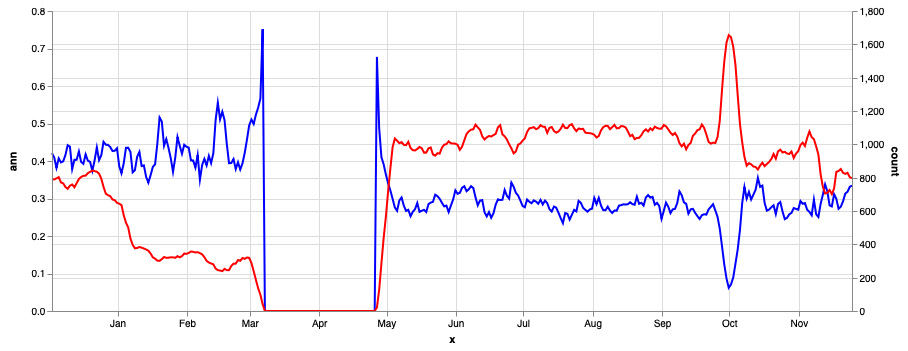

In [70]:
base = alt.Chart(min_dist_df).encode(
    alt.X('x',
        axis=alt.Axis(format='%b'),
        scale=alt.Scale(zero=False)
    )
)
line_count = base.mark_line(color='blue').encode(
    y='ann'
)
line =  base.mark_line(color='red').encode(
    y='count',
)
alt.layer(
    line_count,
    line
).resolve_scale(
    y='independent'
).properties(
    width=800,
    height=300
)